<a href="https://colab.research.google.com/github/sergejhorvat/TinyML-Edx/blob/main/Applications%20of%20TinyML/Zeni_test.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Test notebook

#Installs and dependencies


In [2]:
# for audio import functions
!pip install ffmpeg-python &> 0
!pip install tensorflow-io &> 0
!pip install python_speech_features &> 0
#!pip install tensorflow --ignore-installed --user
print("Packages Installed")

Packages Installed


In [3]:
# Imports
import tensorflow as tf
import datetime
# Load the TensorBoard notebook extension
%load_ext tensorboard

# For audio inport funcion
from IPython.display import HTML, Audio
from google.colab.output import eval_js
from base64 import b64decode
import numpy as np
from scipy.io.wavfile import read as wav_read
import io
import ffmpeg
import tensorflow_io as tfio
import matplotlib.pyplot as plt
import numpy as np
from python_speech_features import mfcc
from matplotlib import cm
import pickle
import librosa
import sys

In [4]:
print(tfio.version.VERSION)

0.26.0


In [5]:
print(tf.__version__)

2.8.2


# Define the audio importing function.

Adapted from: https://ricardodeazambuja.com/deep_learning/2019/03/09/audio_and_video_google_colab/ and https://colab.research.google.com/drive/1Z6VIRZ_sX314hyev3Gm5gBqvm1wQVo-a#scrollTo=RtMcXr3o6gxN

In [9]:
#@title Audio import
AUDIO_HTML = """
<script>
var my_div = document.createElement("DIV");
var my_p = document.createElement("P");
var my_btn = document.createElement("BUTTON");
var t = document.createTextNode("Press to start recording");

my_btn.appendChild(t);
//my_p.appendChild(my_btn);
my_div.appendChild(my_btn);
document.body.appendChild(my_div);

var base64data = 0;
var reader;
var recorder, gumStream;
var recordButton = my_btn;

var handleSuccess = function(stream) {
  gumStream = stream;
  var options = {
    //bitsPerSecond: 8000, //chrome seems to ignore, always 48k
    mimeType : 'audio/webm;codecs=opus'
    //mimeType : 'audio/webm;codecs=pcm'
  };            
  //recorder = new MediaRecorder(stream, options);
  recorder = new MediaRecorder(stream);
  recorder.ondataavailable = function(e) {            
    var url = URL.createObjectURL(e.data);
    var preview = document.createElement('audio');
    preview.controls = true;
    preview.src = url;
    document.body.appendChild(preview);

    reader = new FileReader();
    reader.readAsDataURL(e.data); 
    reader.onloadend = function() {
      base64data = reader.result;
      //console.log("Inside FileReader:" + base64data);
    }
  };
  recorder.start();
  };

recordButton.innerText = "Recording... press to stop";

navigator.mediaDevices.getUserMedia({audio: true}).then(handleSuccess);


function toggleRecording() {
  if (recorder && recorder.state == "recording") {
      recorder.stop();
      gumStream.getAudioTracks()[0].stop();
      recordButton.innerText = "Saving the recording... pls wait!"
  }
}

// https://stackoverflow.com/a/951057
function sleep(ms) {
  return new Promise(resolve => setTimeout(resolve, ms));
}

var data = new Promise(resolve=>{
//recordButton.addEventListener("click", toggleRecording);
recordButton.onclick = ()=>{
toggleRecording()

sleep(2000).then(() => {
  // wait 2000ms for the data to be available...
  // ideally this should use something like await...
  //console.log("Inside data:" + base64data)
  resolve(base64data.toString())

});

}
});
      
</script>
"""

def get_audio():
  display(HTML(AUDIO_HTML))
  data = eval_js("data")
  binary = b64decode(data.split(',')[1])
  
  process = (ffmpeg
    .input('pipe:0')
    .output('pipe:1', format='wav')
    .run_async(pipe_stdin=True, pipe_stdout=True, pipe_stderr=True, quiet=True, overwrite_output=True)
  )
  output, err = process.communicate(input=binary)
  
  riff_chunk_size = len(output) - 8
  # Break up the chunk size into four bytes, held in b.
  q = riff_chunk_size
  b = []
  for i in range(4):
      q, r = divmod(q, 256)
      b.append(r)

  # Replace bytes 4:8 in proc.stdout with the actual size of the RIFF chunk.
  riff = output[:4] + bytes(b) + output[8:]

  sr, audio = wav_read(io.BytesIO(riff))

  return audio, sr

print("Chrome Audio Recorder Defined")

Chrome Audio Recorder Defined


# Audio Samples

##Record your own audio samples!
After you run each cell wait for the stop button to appear then start recording and then press the button to stop the recording once you have said the word! If you do not want to record audio then see below for a way to load in the default audio used in the lecture slides.

In [22]:
audio_yes_loud, sr_yes_loud = get_audio()
print("DONE")

DONE


In [23]:
audio_yes_quiet, sr_yes_quiet = get_audio()
print("DONE")       

DONE


In [25]:
audio_no_loud, sr_no_loud = get_audio()
print("DONE")

DONE


In [26]:
audio_no_quiet, sr_no_quiet = get_audio()
print("DONE")

DONE


##Save audio to files


In [27]:
audio_files = {
   'audio_yes_loud': audio_yes_loud, 'sr_yes_loud': sr_yes_loud,
   'audio_yes_quiet': audio_yes_quiet, 'sr_yes_quiet': sr_yes_quiet,
   'audio_no_loud': audio_no_loud, 'sr_no_loud': sr_no_loud,
   'audio_no_quiet': audio_no_quiet, 'sr_no_quiet': sr_no_quiet,
}
with open('audio_files.pkl', 'wb') as fid:
   pickle.dump(audio_files,fid)

## Load audio files from disk

In [6]:
fid = open('audio_files.pkl', 'rb')
audio_files = pickle.load(fid)
audio_yes_loud = audio_files['audio_yes_loud']
sr_yes_loud = audio_files['sr_yes_loud']
audio_yes_quiet = audio_files['audio_yes_quiet']
sr_yes_quiet = audio_files['sr_yes_quiet']
audio_no_loud = audio_files['audio_no_loud']
sr_no_loud = audio_files['sr_no_loud']
audio_no_quiet = audio_files['audio_no_quiet']
sr_no_quiet = audio_files['sr_no_quiet']

FileNotFoundError: ignored

# Lets do some exploratory data analysis

## Visualize 

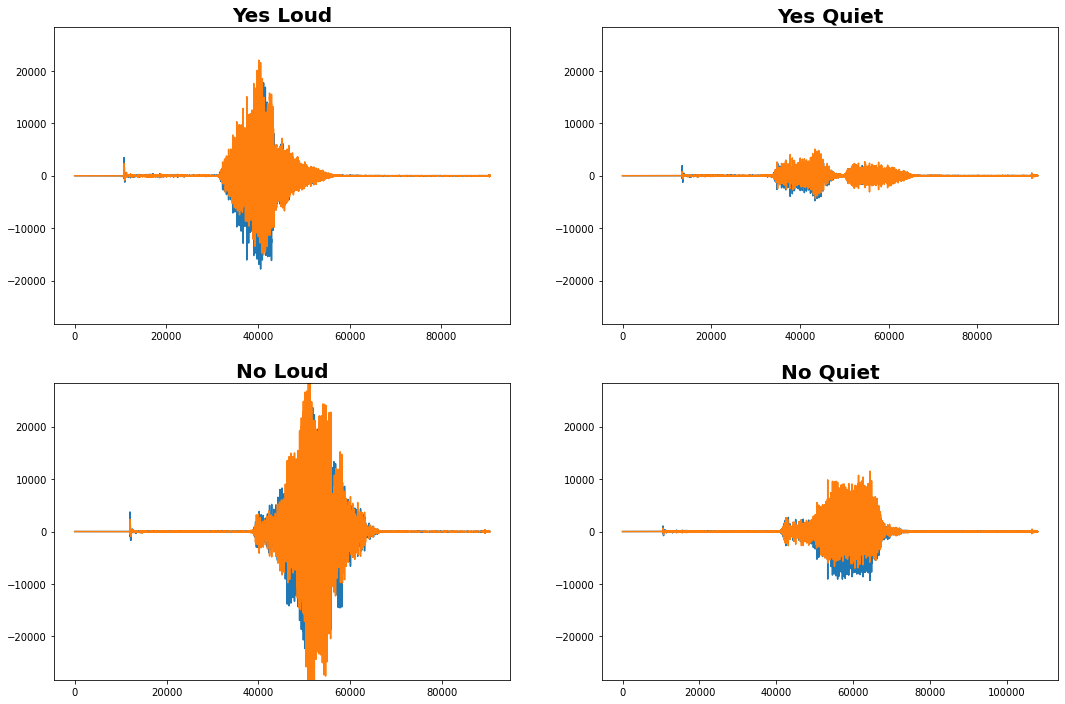

In [28]:
# Plot the figure
fig, ((ax1, ax2), (ax3, ax4)) = plt.subplots(nrows=2, ncols=2)
max_val = max(np.append(np.append(np.append(audio_yes_loud,audio_yes_quiet),audio_no_loud),audio_no_quiet))
ax1.plot(audio_yes_loud)
ax1.set_title("Yes Loud", {'fontsize':20, 'fontweight':'bold'})
ax1.set_ylim(-max_val, max_val)
ax2.plot(audio_yes_quiet)
ax2.set_title("Yes Quiet", {'fontsize':20, 'fontweight':'bold'})
ax2.set_ylim(-max_val, max_val)
ax3.plot(audio_no_loud)
ax3.set_title("No Loud", {'fontsize':20, 'fontweight':'bold'})
ax3.set_ylim(-max_val, max_val)
ax4.plot(audio_no_quiet)
ax4.set_title("No Quiet", {'fontsize':20, 'fontweight':'bold'})
ax4.set_ylim(-max_val, max_val)
fig.set_size_inches(18,12)

# Check the recording shape, had issue with FFT

In [29]:
audio_yes_loud #stereo signal!

array([[  0,   0],
       [  0,   0],
       [  0,   0],
       ...,
       [ 56, -19],
       [-35, -69],
       [-74, -45]], dtype=int16)

In [30]:
audio_yes_loud.shape

(90552, 2)

In [31]:
audio_yes_loud[:,0] # left channel

array([  0,   0,   0, ...,  56, -35, -74], dtype=int16)

## Frequency domain visualization with the FFT

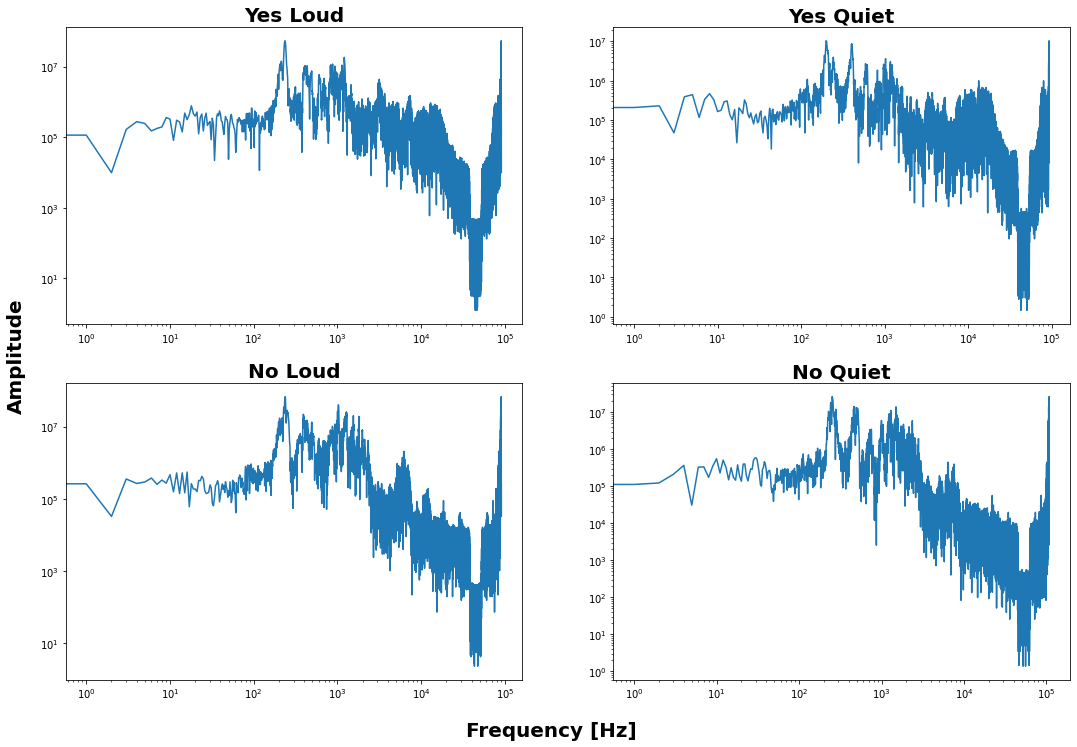

In [32]:
#Adapted from https://makersportal.com/blog/2018/9/13/audio-processing-in-python-part-i-sampling-and-the-fast-fourier-transform
# compute the FFT and take the single-sided spectrum only and remove imaginary part
# take only one channel of recorded stereo input
fig, ((ax1, ax2), (ax3, ax4)) = plt.subplots(nrows=2, ncols=2)
ft_audio_yes_loud = np.abs(2*np.fft.fft(audio_yes_loud[:,0]))
ft_audio_yes_quiet = np.abs(2*np.fft.fft(audio_yes_quiet[:,0]))
ft_audio_no_loud = np.abs(2*np.fft.fft(audio_no_loud[:,0]))
ft_audio_no_quiet = np.abs(2*np.fft.fft(audio_no_quiet[:,0]))

# Plot the figure
ax1.plot(ft_audio_yes_loud)
ax1.set_xscale('log')
ax1.set_yscale('log')
ax1.set_title("Yes Loud", {'fontsize':20, 'fontweight':'bold'})
ax2.plot(ft_audio_yes_quiet)
ax2.set_xscale('log')
ax2.set_yscale('log')
ax2.set_title("Yes Quiet", {'fontsize':20, 'fontweight':'bold'})
ax3.plot(ft_audio_no_loud)
ax3.set_xscale('log')
ax3.set_yscale('log')
ax3.set_title("No Loud", {'fontsize':20, 'fontweight':'bold'})
ax4.plot(ft_audio_no_quiet)
ax4.set_xscale('log')
ax4.set_yscale('log')
ax4.set_title("No Quiet", {'fontsize':20, 'fontweight':'bold'})
fig.set_size_inches(18,12)
fig.text(0.5, 0.06, 'Frequency [Hz]', {'fontsize':20, 'fontweight':'bold'}, ha='center');
fig.text(0.08, 0.5, 'Amplitude', {'fontsize':20, 'fontweight':'bold'}, va='center', rotation='vertical');

## Spectograms

### Test spectogram

In [33]:
# Prepare data for plot
audio_yes_loud_tensor = tf.squeeze(audio_yes_loud[:,0])
audio_yes_loud_tensor = tf.cast(audio_yes_loud_tensor,tf.float32)

In [34]:
audio_yes_loud_tensor

<tf.Tensor: shape=(90552,), dtype=float32, numpy=array([  0.,   0.,   0., ...,  56., -35., -74.], dtype=float32)>

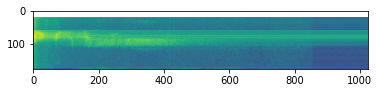

In [35]:
spectrogram = tfio.audio.spectrogram(
    audio_yes_loud_tensor, 
    nfft=2048, 
    window=len(audio_yes_loud_tensor), 
    stride=512)

plt.figure()
plt.imshow(tf.math.log(spectrogram).numpy())


### All data in spectograms

In [36]:
len(audio_yes_loud[:,0])

90552

In [37]:
int(len(audio_yes_loud[:,0]) * 0.008)

724

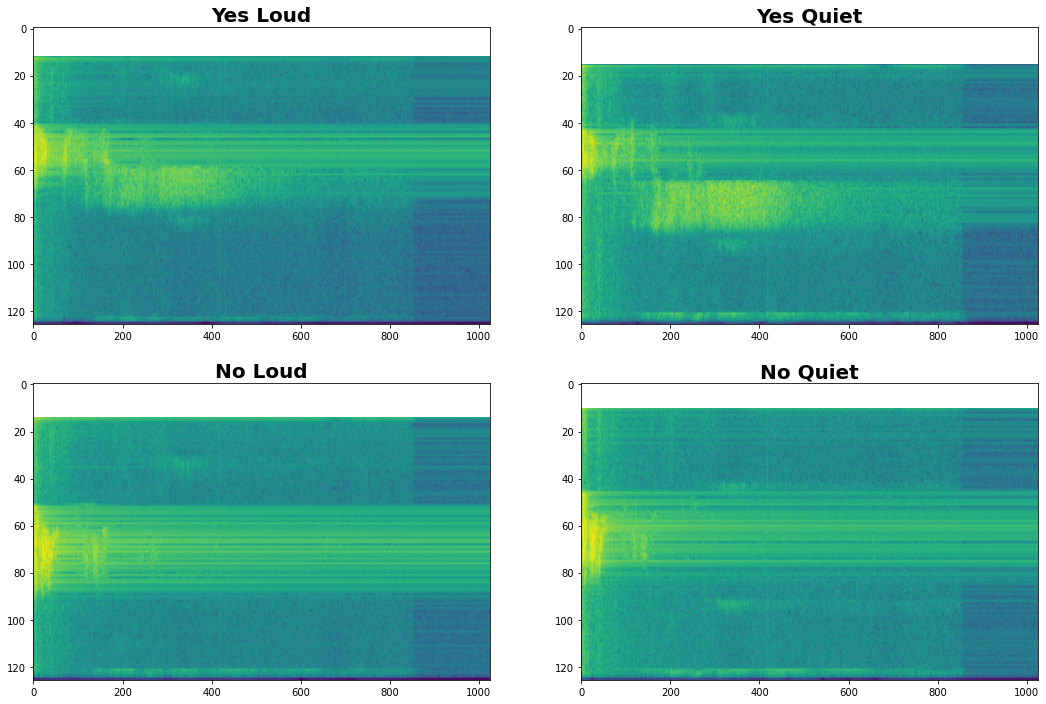

In [38]:
# Convert to spectrogram and display
# adapted from https://aruno14.medium.com/comparaison-of-audio-representation-in-tensorflow-b6c33a83d77f
STRIDE_VALUE =  0.008
spectrogram_yes_loud = tfio.audio.spectrogram(audio_yes_loud[:,0]/1.0, 
                                              nfft=2048, 
                                              window=len(audio_yes_loud[:,0]), 
                                              stride=int(len(audio_yes_loud[:,0]) * STRIDE_VALUE))
spectrogram_yes_quiet = tfio.audio.spectrogram(audio_yes_quiet[:,0]/1.0, 
                                               nfft=2048, 
                                               window=len(audio_yes_quiet[:,0]), 
                                               stride=int(len(audio_yes_quiet[:,0]) * STRIDE_VALUE))
spectrogram_no_loud = tfio.audio.spectrogram(audio_no_loud[:,0]/1.0, 
                                             nfft=2048, 
                                             window=len(audio_no_loud[:,0]), 
                                             stride=int(len(audio_no_loud[:,0]) * STRIDE_VALUE))
spectrogram_no_quiet = tfio.audio.spectrogram(audio_no_quiet[:,0]/1.0,
                                              nfft=2048, 
                                              window=len(audio_no_quiet[:,0]),
                                              stride=int(len(audio_no_quiet[:,0]) * STRIDE_VALUE))

# Plot the figure
fig, ((ax1, ax2), (ax3, ax4)) = plt.subplots(nrows=2, ncols=2)
ax1.imshow(tf.math.log(spectrogram_yes_loud).numpy(), aspect='auto')
ax1.set_title("Yes Loud", {'fontsize':20, 'fontweight':'bold'})
ax2.imshow(tf.math.log(spectrogram_yes_quiet).numpy(), aspect='auto')
ax2.set_title("Yes Quiet", {'fontsize':20, 'fontweight':'bold'})
ax3.imshow(tf.math.log(spectrogram_no_loud).numpy(), aspect='auto')
ax3.set_title("No Loud", {'fontsize':20, 'fontweight':'bold'})
ax4.imshow(tf.math.log(spectrogram_no_quiet).numpy(), aspect='auto')
ax4.set_title("No Quiet", {'fontsize':20, 'fontweight':'bold'})
fig.set_size_inches(18,12)

## MEL Scale (approximates homal spectral hearing)

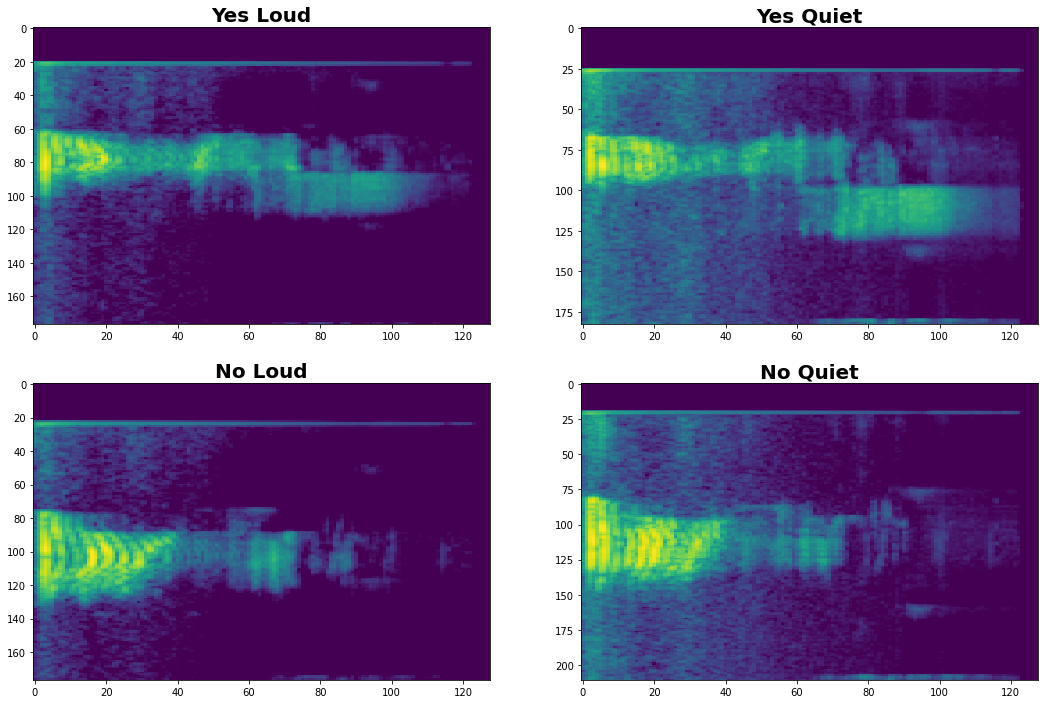

In [39]:
# Convert to MFCC using the Mel Scale
# adapted from: https://towardsdatascience.com/getting-to-know-the-mel-spectrogram-31bca3e2d9d0
mfcc_yes_loud = librosa.power_to_db(librosa.feature.melspectrogram(np.float32(audio_yes_loud[:,0]),
                                                                   sr=sr_yes_loud, 
                                                                   n_fft=2048, 
                                                                   hop_length=512, 
                                                                   n_mels=128),
                                     ref=np.max)

mfcc_yes_quiet = librosa.power_to_db(librosa.feature.melspectrogram(np.float32(audio_yes_quiet[:,0]), 
                                                                    sr=sr_yes_quiet, 
                                                                    n_fft=2048,
                                                                    hop_length=512,
                                                                    n_mels=128),
                                      ref=np.max)

mfcc_no_loud = librosa.power_to_db(librosa.feature.melspectrogram(np.float32(audio_no_loud[:,0]),
                                                                  sr=sr_no_loud,
                                                                  n_fft=2048,
                                                                  hop_length=512,
                                                                  n_mels=128),
                                    ref=np.max)

mfcc_no_quiet = librosa.power_to_db(librosa.feature.melspectrogram(np.float32(audio_no_quiet[:,0]),
                                                                   sr=sr_no_quiet,
                                                                   n_fft=2048,
                                                                   hop_length=512,
                                                                   n_mels=128),
                                     ref=np.max)

# Plot the figure
fig, ((ax1, ax2), (ax3, ax4)) = plt.subplots(nrows=2, ncols=2)
ax1.imshow(np.swapaxes(mfcc_yes_loud, 0 ,1), interpolation='nearest', cmap=cm.viridis, origin='lower', aspect='auto')
ax1.set_title("Yes Loud", {'fontsize':20, 'fontweight':'bold'})
ax1.set_ylim(ax1.get_ylim()[::-1])
ax2.imshow(np.swapaxes(mfcc_yes_quiet, 0 ,1), interpolation='nearest', cmap=cm.viridis, origin='lower', aspect='auto')
ax2.set_title("Yes Quiet", {'fontsize':20, 'fontweight':'bold'})
ax2.set_ylim(ax2.get_ylim()[::-1])
ax3.imshow(np.swapaxes(mfcc_no_loud, 0 ,1), interpolation='nearest', cmap=cm.viridis, origin='lower', aspect='auto')
ax3.set_title("No Loud", {'fontsize':20, 'fontweight':'bold'})
ax3.set_ylim(ax3.get_ylim()[::-1])
ax4.imshow(np.swapaxes(mfcc_no_quiet, 0 ,1), interpolation='nearest', cmap=cm.viridis, origin='lower', aspect='auto')
ax4.set_title("No Quiet", {'fontsize':20, 'fontweight':'bold'})
ax4.set_ylim(ax4.get_ylim()[::-1])
fig.set_size_inches(18,12)

# Train a model from a Pete Wared dataset "speech commands 0.0.2"

# Load trained tflite command word model and convert it to TFlite for microcontrollers

In [46]:
# We add this path so we can import the speech processing modules.
sys.path.append("/content/tensorflow/tensorflow/examples/speech_commands/")
!pip install tensorflow_datasets
import tensorflow_datasets
tf.keras.datasets.
#import tensorflow_datasets.load('input_data')
#import input_data
#import models
import glob
import os
import re
import shutil
from google.colab import files

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


## Download TFlite to TFlite for micorocontroller converter

In [7]:
!apt-get update && apt-get -qq install xxd

Hit:1 https://developer.download.nvidia.com/compute/cuda/repos/ubuntu1804/x86_64  InRelease
Get:2 https://cloud.r-project.org/bin/linux/ubuntu bionic-cran40/ InRelease [3,626 B]
Ign:3 https://developer.download.nvidia.com/compute/machine-learning/repos/ubuntu1804/x86_64  InRelease
Hit:4 https://developer.download.nvidia.com/compute/machine-learning/repos/ubuntu1804/x86_64  Release
Hit:5 http://archive.ubuntu.com/ubuntu bionic InRelease
Hit:6 http://ppa.launchpad.net/c2d4u.team/c2d4u4.0+/ubuntu bionic InRelease
Get:7 http://security.ubuntu.com/ubuntu bionic-security InRelease [88.7 kB]
Get:8 http://archive.ubuntu.com/ubuntu bionic-updates InRelease [88.7 kB]
Get:9 http://archive.ubuntu.com/ubuntu bionic-backports InRelease [74.6 kB]
Hit:10 http://ppa.launchpad.net/cran/libgit2/ubuntu bionic InRelease
Hit:11 http://ppa.launchpad.net/deadsnakes/ppa/ubuntu bionic InRelease
Hit:12 http://ppa.launchpad.net/graphics-drivers/ppa/ubuntu bionic InRelease
Get:14 http://archive.ubuntu.com/ubuntu b

In [8]:
MODEL_TFLITE = 'model.tflite' # uploaded manualy 
MODEL_TFLITE_MICRO = 'model.cc' # converted model name
!xxd -i {MODEL_TFLITE} > {MODEL_TFLITE_MICRO}
REPLACE_TEXT = MODEL_TFLITE.replace('/', '_').replace('.', '_')
!sed -i 's/'{REPLACE_TEXT}'/g_model/g' {MODEL_TFLITE_MICRO}

In [1]:
!cat {MODEL_TFLITE_MICRO}

cat: {MODEL_TFLITE_MICRO}: No such file or directory
